In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [4]:
RSEED = 0   # set rseed to 0

#df = pd.read_csv('https://s3.amazonaws.com/projects-rf/clean_data.csv')  # load the data

labels = np.array(df.pop('label'))

train, test, train_labels, test_labels = train_test_split(df, labels, stratify=labels, test_size=0.3, random_state = RSEED)


In [7]:
train = train.fillna(train.mean())   # fill nans with means in train dataset
test = test.fillna(test.mean())      # fill nans with means in test dataset

features = list(train.columns)       # save column names into features variable

# Create a random forest model with 100 trees
model = RandomForestClassifier(n_estimators=100, random_state=RSEED, max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)


In [5]:
df.head()

,_STATE,FMONTH,DISPCODE,SEQNO,_PSU,CTELENUM,PVTRESD1,COLGHOUS,STATERES,CELLFON3,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,49.0,4.0,1100.0,2.015009e+09,2.015009e+09,NaN,NaN,NaN,NaN,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
1,9.0,9.0,1100.0,2.015005e+09,2.015005e+09,1.0,1.0,NaN,1.0,1.0,...,2.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
2,34.0,10.0,1100.0,2.015011e+09,2.015011e+09,NaN,NaN,NaN,NaN,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
3,41.0,4.0,1100.0,2.015002e+09,2.015002e+09,1.0,1.0,NaN,1.0,1.0,...,2.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0
4,54.0,5.0,1100.0,2.015004e+09,2.015004e+09,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0


In [10]:
model.fit(train, train_labels) # fit random forest model on train data


n_nodes = []  # create an empty variable of n_nodes
max_depths = []  # create an empty for max depth of the tree


for ind_tree in model.estimators_:    # appending statistics of trees in random forest
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')   # printing avaeage number of nodes
print(f'Average maximum depth {int(np.mean(max_depths))}')   # printing average number of max depth


train_rf_predictions = model.predict(train)       # predicting training set 
train_rf_probs = model.predict_proba(train)[:, 1]  # predict probability 



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Average number of nodes 13471
Average maximum depth 45


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished


In [11]:

rf_predictions = model.predict(test)   # predict on test set
rf_probs = model.predict_proba(test)[:, 1]    # predict probability on test set

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve  # importing score packages
import matplotlib.pyplot as plt

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


Recall Baseline: 1.0 Test: 0.96 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.87 Train: 1.0


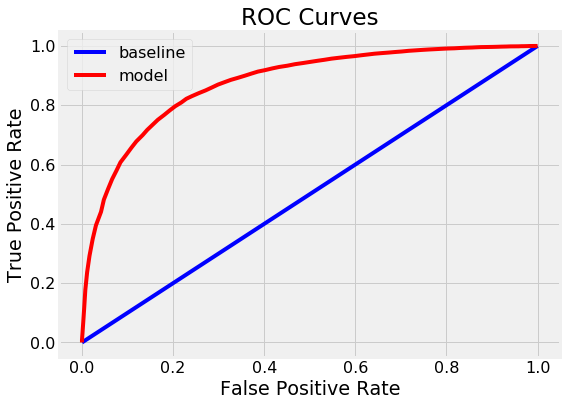

Confusion matrix, without normalization
[[ 2425  3149]
 [  965 23377]]


<Figure size 432x288 with 0 Axes>

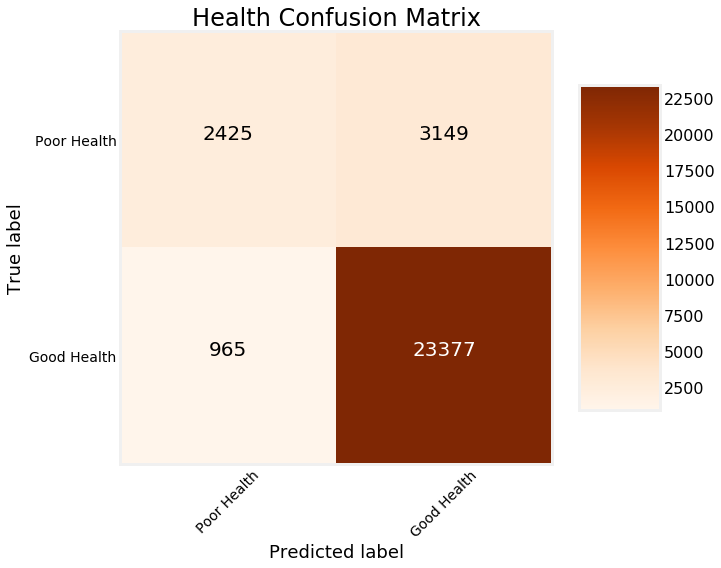

In [12]:
def evaluate_model(predictions, probs, train_predictions, train_probs):   # function to evaluate the model
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}   # create an empty dict
    
    baseline['recall'] = recall_score(test_labels,  # write recall_score by creatong a new col named recall
                                     [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, # sam for precision
                                      [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5    # set roc to 0.5
    
    results = {}    # empty dict name results
    
    results['recall'] = recall_score(test_labels, predictions)   # writing score infos in results
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}    # writing score infos for train predictions into train_results
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:    # printing metrics
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # claculating false positive rates and true negative rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))    # set figure parameters 
    plt.rcParams['font.size'] = 16
    
    
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')  # plot roc curve for test labels
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')   # plot roc curve for
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs) # run the function
plt.savefig('roc_auc_curve.png') # save figure

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,     # function to plot a confusion matrix
                          normalize=False, # default = not normalized
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:     # if confusion matrix is normalized then convert cm to type float and normalize it 
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'  # set format to 2 floats after point for normalized and to double if not
    thresh = cm.max() / 2.             # set a thresh by dividing the max of confusion matrix by 2
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)     # disable grid of plot
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(test_labels, rf_predictions)    # generate confúsion matrix
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

plt.savefig('cm.png')